### Code based of the tutorial at: https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-2-ded33892c724

In [1]:
import gym
import time
import tensorflow as tf
import tflearn
import numpy as np
import matplotlib
import seaborn as sns
%matplotlib inline

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
env = gym.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
observation = tflearn.input_data(shape=[None, 4])
net = tflearn.fully_connected(observation, 256, activation="relu")
net = tflearn.fully_connected(net, 256, activation="relu")
net = tflearn.fully_connected(net, 256, activation="relu")
out = tflearn.fully_connected(net, 2, activation="softmax")

reward_holder = tf.placeholder(tf.float32, [None])
action_holder = tf.placeholder(tf.int32, [None])

responsible_outputs = tf.gather(tf.reshape(out, [-1]), tf.range(0, tf.shape(out)[0] * tf.shape(out)[1], 2) + action_holder)

loss = -tf.reduce_mean(tf.log(responsible_outputs) * reward_holder)

optimizer = tf.train.AdamOptimizer()
update = optimizer.minimize(loss)

C:\Users\Edan\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [4]:
gamma = 0.99

def discount_reward(rewards):
    running_reward = 0
    result = np.zeros_like(rewards)
    for i in reversed(range(len(rewards))):
        result[i] = rewards[i] + gamma * running_reward
        running_reward += rewards[i]
    return result

In [5]:
num_episodes = 1500
max_time = 200
all_rewards = []
saver = tf.train.Saver()
train_data = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_episodes):
        obs = env.reset()
        episode_reward = 0
        ep_history = []
        for j in range(max_time):
            #Choose an action
            a_one_hot = sess.run(out, feed_dict={observation: [obs]}).reshape(2)
            action = np.random.choice(a_one_hot, p=a_one_hot)
            action = np.argmax(a_one_hot == action)
            obs1, r, d, _ = env.step(action)
            ep_history.append([obs, r, action])
            obs = obs1
            episode_reward += r
            if d == True:
                all_rewards.append(episode_reward)
                ep_history = np.array(ep_history)
                ep_history[:, 1] = discount_reward(ep_history[:, 1])
                train_data.extend(ep_history)
                if i % 10 == 0 and i != 0:
                    train_data = np.array(train_data)
                    sess.run(update, feed_dict={observation: np.vstack(train_data[:, 0]),
                                                    reward_holder: train_data[:, 1],
                                                    action_holder: train_data[:, 2]})
                    train_data = []
                break
                
        if i % 100 == 0 and i != 0:
            print(np.mean(all_rewards[-100:]))
            if np.mean(all_rewards[-100:]) == 200:
                break
            
    saver.save(sess, "/tmp/model.ckpt")

22.59
30.67
44.47
73.87
103.54
150.14
198.28
175.09
136.79
190.22
200.0
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'NoneType' object has no attribute 'name'


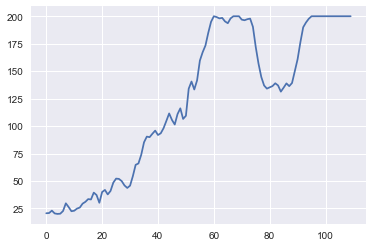

In [6]:
avg_reward = [np.mean(all_rewards[i-10:i+10]) for i in range(10, len(all_rewards))]
sns.plt.plot(avg_reward[::10])

In [7]:
max_time = 200
saver = tf.train.Saver()
    
with tf.Session() as sess:
    saver.restore(sess, "/tmp/model.ckpt")
    #Show the results
    for i in range(10):
        obs = env.reset()
        episode_reward = 0
        for j in range(max_time):
            #Choose an action
            a_one_hot = sess.run(out, feed_dict={observation: [obs]}).reshape(2)
            action = np.random.choice(a_one_hot, p=a_one_hot)
            action = np.argmax(a_one_hot == action)
            env.render()
            time.sleep(0.005)
            obs, r, d, _ = env.step(action)
            episode_reward += r
            if d == True:
                break
        print(episode_reward)

200.0
200.0
200.0
200.0
200.0
200.0
200.0
200.0
200.0
200.0
